# Tuning a Convolutional Network

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'

import torch.utils.tensorboard as tb

log_dir = 'logs'

/Users/simanerush/anaconda3/envs/dl-class/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/simanerush/anaconda3/envs/dl-class/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/simanerush/anaconda3/envs/dl-class/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/simanerush/anaconda3/envs/dl-class/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([
    transforms.ToImageTensor(),
    transforms.ConvertImageDtype()
])

cifar = torchvision.datasets.CIFAR10("../../data/torch/cifar", download=True, transform=transform)
train_size = int(0.8 * len(cifar))
train_data, valid_data = torch.utils.data.random_split(cifar, [train_size, len(cifar) - train_size])

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(len(cifar))

Files already downloaded and verified
50000


In [3]:
mean = []
for x, _ in cifar:
    mean.append(torch.mean(x, dim=(1, 2)))
mean = torch.stack(mean, dim=0).mean(dim=0)
std = []
for x, _ in cifar:
    std.append(((x - mean[:,np.newaxis,np.newaxis]) ** 2).mean(dim=(1, 2)))
std = torch.stack(std, dim=0).mean(dim=0).sqrt()
print(mean, std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [4]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

normalize = transforms.Normalize(cifar_mean, cifar_std)

if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = 'cpu'
print(device)

mps


## CNN Model



This is the model from the previous HW, let's see if it's possible to improve it.

In [5]:
class CNN(nn.Module):

    def __init__(self):
        # 5 layers is normal
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(8, 16, 3, groups=2, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(16, 32, 3, stride=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*8*8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Training function:

In [70]:
def train(model_class=CNN, lr=1e-2, epochs=10, batch_size=64, reg=1e-4, use_augmentation=False, aug_params=None):
 
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    if use_augmentation:
        augments = transforms.Compose([
            transforms.RandomHorizontalFlip(aug_params['flip_prob']),
            transforms.RandomGrayscale(aug_params['grayscale_prob']),
            transforms.ColorJitter(
                brightness=(aug_params['bright_min'], aug_params['bright_max']),
                contrast=0,
                saturation=0,
                hue=0),
            transforms.RandomCrop(
                size=32,
                padding=aug_params['shift_size'],
                fill=cifar_mean)
        ])
    
    model_type = ''
    if model_class == CNN:
        network = CNN()
        model_type = 'CNN'
    elif model_class == CNN2:
        network = CNN2()
        model_type = 'CNN2'
    elif model_class == CNN3:
        network = CNN3()
        model_type = 'CNN3'
    elif model_class == CNN4:
        network = CNN4()
        model_type = 'CNN4'
    elif model_class == CNN5:
        network = CNN5()
        model_type = 'CNN5'

    network = network.to(device)

    logger = tb.SummaryWriter(log_dir + '/' + model_type + '-lr-' + str(lr) + '-epochs-' + str(epochs))

    global_step = 0
    
    loss = nn.CrossEntropyLoss()
    opt = optim.SGD(network.parameters(), momentum=0.9, lr=lr, weight_decay=reg)
    
    valid_accs = []

    for i in tqdm(range(epochs)):
        network.train()
        for batch_xs, batch_ys in data_loader:
            if use_augmentation:
                batch_xs = augments(batch_xs)

            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)
            
            batch_xs = normalize(batch_xs)
            preds = network(batch_xs)
            loss_val = loss(preds, batch_ys)
            acc = (preds.argmax(dim=1) == batch_ys).float().mean()

            # Track loss and traning accuracy.
            logger.add_scalar('loss', loss_val, global_step=global_step)
            logger.add_scalar('training accuracy', acc, global_step=global_step)

            global_step += 1

            opt.zero_grad()
            loss_val.backward()
            opt.step()
        
        network.eval()
        # Measure validation accuracy.
        for batch_xs, batch_ys in valid_loader:
            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)
            
            batch_xs = normalize(batch_xs)
            preds = network(batch_xs)
            valid_accs.append((preds.argmax(dim=1) == batch_ys).float().mean().item())

        if (i + 1) % 5 == 0:
            print("Epoch:", i, "Validation accuracy:", torch.tensor(valid_accs).mean().item())
        logger.add_scalar('validation accuracy', torch.tensor(valid_accs).mean(), global_step=global_step)


    return network

## Tuning

The default arguments to the training function are as follows:
- Learning rate `lr`: 1e-2
- Epochs number `epochs`: 10
- Batch size `batch_size`: 64
- Regularization `reg`: 1e-4 (based on the [Medium article](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9))
- Augmentation: None


The TensorBoard logger is tracking loss, and training accuracy for each batch. It is also tracking validation accuracy for each epoch.

First, let's try to train with the default parameters described above.

The straregy is to first find a learning rate that works with this architecture and try to change it in some way.


In [75]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 8566), started 5:04:48 ago. (Use '!kill 8566' to kill it.)

In [13]:
model1_default = train()

 10%|█         | 1/10 [00:06<00:54,  6.09s/it]

Epoch: 0 Validation accuracy: 0.48696258664131165


 20%|██        | 2/10 [00:12<00:48,  6.08s/it]

Epoch: 1 Validation accuracy: 0.5178642272949219


 30%|███       | 3/10 [00:18<00:42,  6.06s/it]

Epoch: 2 Validation accuracy: 0.5311504602432251


 40%|████      | 4/10 [00:24<00:36,  6.12s/it]

Epoch: 3 Validation accuracy: 0.5451333522796631


 50%|█████     | 5/10 [00:30<00:30,  6.11s/it]

Epoch: 4 Validation accuracy: 0.5542794466018677


 60%|██████    | 6/10 [00:36<00:24,  6.10s/it]

Epoch: 5 Validation accuracy: 0.5604265928268433


 70%|███████   | 7/10 [00:42<00:18,  6.07s/it]

Epoch: 6 Validation accuracy: 0.564078152179718


 80%|████████  | 8/10 [00:48<00:12,  6.16s/it]

Epoch: 7 Validation accuracy: 0.5678741931915283


 90%|█████████ | 9/10 [00:54<00:06,  6.13s/it]

Epoch: 8 Validation accuracy: 0.5695992708206177


100%|██████████| 10/10 [01:01<00:00,  6.10s/it]

Epoch: 9 Validation accuracy: 0.5718252658843994


I got accuracy 57% with the starting learning rate of 1e-2. Let's try 3e-2, a larger learning rate:

In [15]:
model2_large_lr = train(lr=3e-2)

 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Epoch: 0 Validation accuracy: 0.48895302414894104


 20%|██        | 2/10 [00:11<00:47,  5.91s/it]

Epoch: 1 Validation accuracy: 0.5183120965957642


 30%|███       | 3/10 [00:17<00:41,  5.86s/it]

Epoch: 2 Validation accuracy: 0.5298566818237305


 40%|████      | 4/10 [00:23<00:34,  5.83s/it]

Epoch: 3 Validation accuracy: 0.5333399772644043


 50%|█████     | 5/10 [00:29<00:29,  5.81s/it]

Epoch: 4 Validation accuracy: 0.5389530062675476


 60%|██████    | 6/10 [00:35<00:23,  5.84s/it]

Epoch: 5 Validation accuracy: 0.5401240587234497


 70%|███████   | 7/10 [00:41<00:17,  5.93s/it]

Epoch: 6 Validation accuracy: 0.5390838384628296


 80%|████████  | 8/10 [00:47<00:11,  5.97s/it]

Epoch: 7 Validation accuracy: 0.5397716164588928


 90%|█████████ | 9/10 [00:53<00:05,  5.98s/it]

Epoch: 8 Validation accuracy: 0.544221043586731


100%|██████████| 10/10 [00:59<00:00,  5.92s/it]

Epoch: 9 Validation accuracy: 0.5459494590759277


This gave worse results, so let's stick with `1e-2`, increase number of epochs and add augmentation:

In [22]:
aug_params = {
    'flip_prob': 0.5,
    'grayscale_prob': 0.1,
    'bright_min': 0.9,
    'bright_max': 1.1,
    'shift_size': 2
}

model3_epochs_aug = train(epochs=20, use_augmentation=True, aug_params=aug_params)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:06<01:59,  6.29s/it]

Epoch: 0 Validation accuracy: 0.43680334091186523


 10%|█         | 2/20 [00:12<01:52,  6.23s/it]

Epoch: 1 Validation accuracy: 0.47526872158050537


 15%|█▌        | 3/20 [00:18<01:45,  6.20s/it]

Epoch: 2 Validation accuracy: 0.5010947585105896


 20%|██        | 4/20 [00:24<01:39,  6.19s/it]

Epoch: 3 Validation accuracy: 0.5183370113372803


 25%|██▌       | 5/20 [00:31<01:32,  6.19s/it]

Epoch: 4 Validation accuracy: 0.5355692505836487


 30%|███       | 6/20 [00:37<01:26,  6.19s/it]

Epoch: 5 Validation accuracy: 0.545166552066803


 35%|███▌      | 7/20 [00:43<01:20,  6.18s/it]

Epoch: 6 Validation accuracy: 0.5549931526184082


 40%|████      | 8/20 [00:49<01:14,  6.18s/it]

Epoch: 7 Validation accuracy: 0.561989963054657


 45%|████▌     | 9/20 [00:55<01:07,  6.18s/it]

Epoch: 8 Validation accuracy: 0.5683828592300415


 50%|█████     | 10/20 [01:01<01:01,  6.18s/it]

Epoch: 9 Validation accuracy: 0.5729398727416992


 55%|█████▌    | 11/20 [01:08<00:55,  6.21s/it]

Epoch: 10 Validation accuracy: 0.5768492817878723


 60%|██████    | 12/20 [01:14<00:50,  6.31s/it]

Epoch: 11 Validation accuracy: 0.5812350511550903


 65%|██████▌   | 13/20 [01:21<00:44,  6.31s/it]

Epoch: 12 Validation accuracy: 0.5848695635795593


 70%|███████   | 14/20 [01:27<00:38,  6.35s/it]

Epoch: 13 Validation accuracy: 0.5875725150108337


 75%|███████▌  | 15/20 [01:33<00:31,  6.36s/it]

Epoch: 14 Validation accuracy: 0.5896961092948914


 80%|████████  | 16/20 [01:40<00:25,  6.36s/it]

Epoch: 15 Validation accuracy: 0.5920083522796631


 85%|████████▌ | 17/20 [01:46<00:19,  6.35s/it]

Epoch: 16 Validation accuracy: 0.5938612222671509


 90%|█████████ | 18/20 [01:52<00:12,  6.35s/it]

Epoch: 17 Validation accuracy: 0.5956630110740662


 95%|█████████▌| 19/20 [01:59<00:06,  6.31s/it]

Epoch: 18 Validation accuracy: 0.5981447100639343


100%|██████████| 20/20 [02:05<00:00,  6.27s/it]

Epoch: 19 Validation accuracy: 0.5996516942977905


Let's use these parameters and define a new model that will hopefully perform better.

In [46]:
class CNN2(nn.Module):

    def __init__(self):
        super().__init__()

        # 32x32
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.relu1 = nn.ReLU()

        # 32x32
        self.conv2 = nn.Conv2d(8, 16, 3, groups=2, padding=1)
        # 16x16
        self.maxpool1 = nn.MaxPool2d(2, 2)

        # 16x16
        self.conv3 = nn.Conv2d(16, 32, 2, padding=1)
        # 8x8
        self.maxpool2 = nn.MaxPool2d(2, 2)

        # 8x8
        self.conv4 = nn.Conv2d(32, 64, 2, padding=1)
        # 4x4
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        # 6x6 (added padding)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=2)
        # 3x3
        self.maxpool4 = nn.MaxPool2d(2, 2)

        # 6x6
        self.avgpool = nn.AdaptiveAvgPool2d(6)

        # 6x6x128
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(6*6*128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.maxpool3(x)
        x = self.conv5(x)
        x = self.maxpool4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Let's train using the above network. Note how I increased the number of convolutional layers. I used maxpools in addition to ReLU in between layers, and removed some strides to not lose too much information. I recorded dimentions of the image after each transformation.

In [47]:
model_cnn2 = train(model_class=CNN2, epochs=20, use_augmentation=True, aug_params=aug_params)

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:42<02:06,  8.41s/it]

Epoch: 4 Validation accuracy: 0.6532842516899109


 50%|█████     | 10/20 [01:25<01:25,  8.52s/it]

Epoch: 9 Validation accuracy: 0.6910131573677063


 75%|███████▌  | 15/20 [02:07<00:41,  8.36s/it]

Epoch: 14 Validation accuracy: 0.706601619720459


100%|██████████| 20/20 [02:49<00:00,  8.46s/it]

Epoch: 19 Validation accuracy: 0.7163962721824646


Wow! I achieved 71% accuracy with the `CNN2` model. The TensorBoard shows that the loss is decreasing faster, and the validation accuracy starts off higher, but increases at the relatively same rate as before. We can also see that the training accuracy is about the same, so it is not overfitting yet. Let's try running it on 50 epochs:

In [51]:
model_cnn2_epochs = train(model_class=CNN2, epochs=50, use_augmentation=True, aug_params=aug_params)

 10%|█         | 5/50 [00:43<06:35,  8.79s/it]

Epoch: 4 Validation accuracy: 0.6308121085166931


 20%|██        | 10/50 [01:28<05:52,  8.81s/it]

Epoch: 9 Validation accuracy: 0.6779458522796631


 30%|███       | 15/50 [02:10<05:02,  8.63s/it]

Epoch: 14 Validation accuracy: 0.6956143975257874


 40%|████      | 20/50 [02:55<04:24,  8.81s/it]

Epoch: 19 Validation accuracy: 0.7077279090881348


 50%|█████     | 25/50 [03:38<03:36,  8.66s/it]

Epoch: 24 Validation accuracy: 0.7146615982055664


 60%|██████    | 30/50 [04:19<02:45,  8.29s/it]

Epoch: 29 Validation accuracy: 0.7206077575683594


 70%|███████   | 35/50 [05:00<02:04,  8.28s/it]

Epoch: 34 Validation accuracy: 0.72548907995224


 80%|████████  | 40/50 [05:42<01:22,  8.30s/it]

Epoch: 39 Validation accuracy: 0.7292247414588928


 90%|█████████ | 45/50 [06:23<00:41,  8.26s/it]

Epoch: 44 Validation accuracy: 0.731050968170166


100%|██████████| 50/50 [07:04<00:00,  8.49s/it]

Epoch: 49 Validation accuracy: 0.7330613136291504


Looks like the accuracy didn't get much better, so let's ADD MORE LAYERS

In [59]:
class CNN3(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.relu1 = nn.ReLU()

        # Use stride instead of group
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)

        # Increase kernel size
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)

        # Increase kernel size
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=2)
        self.maxpool4 = nn.MaxPool2d(2, 2)

        # New layer
        self.conv6 = nn.Conv2d(128, 256, 2, padding=1)  
        self.maxpool5 = nn.MaxPool2d(2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4*4*256, 10)

        # Change output size
        self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4*4*256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.maxpool3(x)
        x = self.conv5(x)
        x = self.maxpool4(x)
        x = self.conv6(x)
        x = self.maxpool5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In the `CNN3` network, I have added a new 6th layer, increased kernel size in some layers, and used stride instead of group in layer 2, maybe that will help a deeper network with extracting more features once the image is downsampled. Or it might become worse because it lost information. Let's test it!

In [60]:
model_cnn3 = train(model_class=CNN3, epochs=20, use_augmentation=True, aug_params=aug_params)

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:45<02:14,  8.99s/it]

Epoch: 4 Validation accuracy: 0.5740246772766113


 50%|█████     | 10/20 [01:29<01:28,  8.86s/it]

Epoch: 9 Validation accuracy: 0.6296078562736511


 75%|███████▌  | 15/20 [02:14<00:44,  8.84s/it]

Epoch: 14 Validation accuracy: 0.6557789444923401


100%|██████████| 20/20 [02:58<00:00,  8.92s/it]

Epoch: 19 Validation accuracy: 0.6661524772644043


This model performs significantly worse, despite more layers. Let's bring back grouping.

In [65]:
class CNN4(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.relu1 = nn.ReLU()

        # Bring grouping back
        self.conv2 = nn.Conv2d(8, 16, 3, groups=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)

        # Increase kernel size
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)

        # Increase kernel size
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=2)
        self.maxpool4 = nn.MaxPool2d(2, 2)

        # New layer
        self.conv6 = nn.Conv2d(128, 256, 2, padding=1)  
        self.maxpool5 = nn.MaxPool2d(2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4*4*256, 10)

        # Change output size
        self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4*4*256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.maxpool3(x)
        x = self.conv5(x)
        x = self.maxpool4(x)
        x = self.conv6(x)
        x = self.maxpool5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Let's try it out:

In [68]:
model_cnn4 = train(model_class=CNN4, epochs=20, use_augmentation=True, aug_params=aug_params)

 25%|██▌       | 5/20 [00:49<02:28,  9.88s/it]

Epoch: 4 Validation accuracy: 0.6454418897628784


 50%|█████     | 10/20 [01:39<01:39,  9.96s/it]

Epoch: 9 Validation accuracy: 0.6910927295684814


 75%|███████▌  | 15/20 [02:28<00:49,  9.81s/it]

Epoch: 14 Validation accuracy: 0.7107285261154175


100%|██████████| 20/20 [03:17<00:00,  9.88s/it]

Epoch: 19 Validation accuracy: 0.721471905708313


Yay! 72% accuracy, with validation accuracy increasing faster than the best-performing `CNN2` model. Let's try to design a final `CNN5`:

In [72]:
class CNN5(nn.Module):

    def __init__(self):
        super().__init__()

        # Give more padding
        self.conv1 = nn.Conv2d(3, 8, 3, padding=2)
        self.relu1 = nn.ReLU()

        # Use paffing = 'same
        self.conv2 = nn.Conv2d(8, 16, 3, groups=2, padding='same')
        self.maxpool1 = nn.MaxPool2d(2, 2)

        # More padding
        self.conv3 = nn.Conv2d(16, 32, 3, padding=2)
        self.maxpool2 = nn.MaxPool2d(2, 2)

        # Use padding = 'same'
        self.conv4 = nn.Conv2d(32, 64, 3, padding='same')
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=2)
        self.maxpool4 = nn.MaxPool2d(2, 2)

        # Use padding = 'same'
        self.conv6 = nn.Conv2d(128, 256, 2, padding='same')  
        self.maxpool5 = nn.MaxPool2d(2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4*4*256, 10)

        # Change output size
        self.avgpool = nn.AdaptiveAvgPool2d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4*4*256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.maxpool3(x)
        x = self.conv5(x)
        x = self.maxpool4(x)
        x = self.conv6(x)
        x = self.maxpool5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Let's try it:

In [73]:
model_cnn5 = train(model_class=CNN5, epochs=20, use_augmentation=True, aug_params=aug_params)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/simanerush/anaconda3/envs/dl-class/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,
 25%|██▌       | 5/20 [00:49<02:27,  9.80s/it]

Epoch: 4 Validation accuracy: 0.631349503993988


 50%|█████     | 10/20 [01:37<01:35,  9.53s/it]

Epoch: 9 Validation accuracy: 0.6717555522918701


 75%|███████▌  | 15/20 [02:24<00:47,  9.48s/it]

Epoch: 14 Validation accuracy: 0.6880506873130798


100%|██████████| 20/20 [03:11<00:00,  9.60s/it]

Epoch: 19 Validation accuracy: 0.6929289698600769


There's no improvement of adding padding, so let's stick with `CNN4` as the final model and train it on 100 epochs.

In [74]:
model_cnn4_epochs = train(model_class=CNN4, epochs=100, use_augmentation=True, aug_params=aug_params)

  5%|▌         | 5/100 [00:47<15:01,  9.49s/it]

Epoch: 4 Validation accuracy: 0.6411823034286499


 10%|█         | 10/100 [01:34<14:11,  9.46s/it]

Epoch: 9 Validation accuracy: 0.6910430192947388


 15%|█▌        | 15/100 [02:22<13:23,  9.46s/it]

Epoch: 14 Validation accuracy: 0.7100782990455627


 20%|██        | 20/100 [03:09<12:36,  9.45s/it]

Epoch: 19 Validation accuracy: 0.7205961346626282


 25%|██▌       | 25/100 [03:56<11:50,  9.47s/it]

Epoch: 24 Validation accuracy: 0.7256727814674377


 30%|███       | 30/100 [04:44<11:02,  9.46s/it]

Epoch: 29 Validation accuracy: 0.7284235954284668


 35%|███▌      | 35/100 [05:32<10:18,  9.52s/it]

Epoch: 34 Validation accuracy: 0.7315570712089539


 40%|████      | 40/100 [06:21<09:47,  9.78s/it]

Epoch: 39 Validation accuracy: 0.7336435317993164


 45%|████▌     | 45/100 [07:08<08:45,  9.56s/it]

Epoch: 44 Validation accuracy: 0.7347885966300964


 50%|█████     | 50/100 [07:55<07:53,  9.47s/it]

Epoch: 49 Validation accuracy: 0.7370680570602417


 55%|█████▌    | 55/100 [08:43<07:05,  9.45s/it]

Epoch: 54 Validation accuracy: 0.7377623915672302


 60%|██████    | 60/100 [09:30<06:17,  9.44s/it]

Epoch: 59 Validation accuracy: 0.7384836077690125


 65%|██████▌   | 65/100 [10:17<05:31,  9.47s/it]

Epoch: 64 Validation accuracy: 0.7399803996086121


 70%|███████   | 70/100 [11:05<04:43,  9.46s/it]

Epoch: 69 Validation accuracy: 0.7414084076881409


 75%|███████▌  | 75/100 [11:51<03:54,  9.37s/it]

Epoch: 74 Validation accuracy: 0.7417781352996826


 80%|████████  | 80/100 [12:38<03:07,  9.38s/it]

Epoch: 79 Validation accuracy: 0.7423853278160095


 85%|████████▌ | 85/100 [13:25<02:20,  9.39s/it]

Epoch: 84 Validation accuracy: 0.7426950931549072


 90%|█████████ | 90/100 [14:12<01:33,  9.39s/it]

Epoch: 89 Validation accuracy: 0.742591142654419


 95%|█████████▌| 95/100 [14:59<00:46,  9.39s/it]

Epoch: 94 Validation accuracy: 0.742329478263855


100%|██████████| 100/100 [15:48<00:00,  9.48s/it]

Epoch: 99 Validation accuracy: 0.7425228953361511


With 100 epochs, the accuracy is 74%, which is pretty good. I think that now I understand how different changes in both hyperparameters and model architecture change its accuracy.

## Conclusion
Even though adding more epochs did not change accuracy that much, we see that adding more layers to a CNN network, and removing strides to avoid downsampling too aggressively, makes a positive impact on the accuracy.
Visualization:

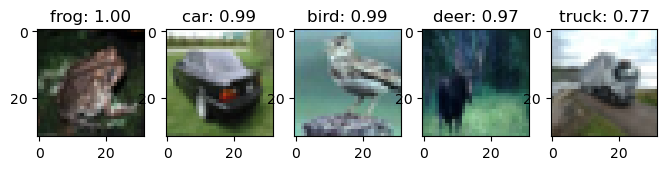

In [83]:
fig, axs = plt.subplots(1, 5, figsize=(8, 8))
for i in range(5):
    r = torch.randint(len(cifar), (1,)).item()
    cifar_gpu = (cifar[r][0]).unsqueeze(0).to(device)

    preds = nn.functional.softmax(model_cnn4_epochs(normalize(cifar_gpu)), dim=1)
        
    preds = preds.cpu()
    c = torch.argmax(preds)
    prob = preds[0, c].item()  # Get probability of the predicted class

    axs[i].imshow(cifar[r][0].numpy().transpose(1, 2, 0))
    axs[i].set_title("{}: {:.2f}".format(classes[c], prob))

plt.show()